In [50]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import utils
from sklearn.metrics import roc_curve, auc
from dataloader import DataLoader
from transfer_classifier import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print("gpu available!")
else:
    device = torch.device('cpu')
    print("gpu NOT available!")

gpu available!


In [3]:
# We need to define the Flatten class again before model is loaded... weird pytorch thing
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = torchvision.models.vgg19(pretrained=True).features

for param in model.parameters():
    param.requires_grad = False
model.eval()
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [54]:
def predict_transfer(model_name, files, x, y, model, model_t):

    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y = y.to(device=device, dtype=torch.long)

    x_slice = model(x)
    x_pooled = pool_batch(x_slice, mode='mean')
    y_pooled = pool_labels(y)

    scores = model_t(x_pooled)
    val_loss = F.cross_entropy(scores, y_pooled)
    
    _, preds = scores.max(1)
    probs = F.softmax(scores, dim=1)[:,1]
    num_correct = (preds == y_pooled).sum()
    num_samples = preds.size(0)
#     with open('patch_results.txt', 'a+') as outfile:
#         for i, pred in enumerate(preds):
#             outfile.write('{}\t{}\t{}\n'.format(model_name, files[i], probs[i]))

    return val_loss.item(), num_correct, num_samples, probs.tolist(), y_pooled.tolist()

In [55]:
def predict(model_name, files, x, y, model):

    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    val_loss = F.cross_entropy(scores, y)
    
    _, preds = scores.max(1)
    probs = F.softmax(scores, dim=1)[:,1]

    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
#     with open('patch_results.txt', 'a+') as outfile:
#         for i, pred in enumerate(preds):
#             outfile.write('{}\t{}\t{}\n'.format(model_name, files[i], probs[i]))

    return val_loss.item(), num_correct, num_samples, probs.tolist(), y.tolist()

In [ ]:
# validation loss by epoch
val_loss_by_epoch = []
for epoch in range(10):
    print('epoch', epoch)
    model_name = 'transfer_epoch{}_v2_maxpool.pt'.format(epoch)
    model_t = torch.load(utils.model_dir + model_name)
    for param in model_t.parameters():
        param.requires_grad = False
    model_t.eval()
    model_t.to(device)

    val_loader = DataLoader(utils.test_dir, batch_size=24, transfer=True)
    val_losses = []
    total_correct = 0
    total = 0
    for i, (f, x, y) in enumerate(val_loader):
        if i % 10 == 0:
            print('on batch', i)
        loss, n_correct, n_samples, probs = predict_transfer(model_name, f, x, y, model, model_t)
        val_losses.append(loss)
        total_correct += n_correct
        total += n_samples
    val_loss_by_epoch.append(np.mean(val_losses))
    print('val loss = {}'.format(np.mean(val_losses)))
    print('val acc = {}'. format(float(total_correct) / total))
    print()

In [ ]:
modelname = 'conv2d_batchnorm'
with open('val_loss_by_epoch.txt'. 'a+') as outfile:
    for e, l in enumerate(val_loss_by_epoch):
        outfile.write('{}\t{}\t{}\n'.format(modelname, e, l))

#### Test set

In [56]:
# model_name = 'transfer_epoch5_v2.pt'
# model_t = torch.load(utils.model_dir + model_name)
# for param in model_t.parameters():
#     param.requires_grad = False
# model_t.eval()
# model_t.to(device)

model_files = ['conv2d_v2_std_epoch4.pt', 'conv2d_v2_batchnorm_std_epoch4.pt', 'transfer_epoch4_v2.pt', 'transfer_epoch4_v2_maxpool.pt']
model_names = ['Modified VGG19', 'Modified VGG19 plus batchnorm', 'VGG pretrained - mean pooling', 'VGG pretrained - max pooling']

tprs = []
fprs = []
rocs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for i, modfile in enumerate(model_files):
        print(modfile)
        model_name = model_names[i]
        model_t = torch.load(utils.model_dir + modfile)
        model_t.eval()
        model_t.to(device)
        if modfile.startswith('conv2d'):
            val_loader = DataLoader(utils.test_dir, batch_size=24, transfer=False)
        else:
            val_loader = DataLoader(utils.test_dir, batch_size=24, transfer=True)
        val_losses = []
        preds = []
        trues = []
        total_correct = 0
        total = 0
        for j, (f, x, y) in enumerate(val_loader):
            if j % 10 == 0:
                print('on batch', j)
            if modfile.startswith('conv2d'):
                loss, n_correct, n_samples, probs, labels = predict(model_name, f, x, y, model_t)
            else:
                loss, n_correct, n_samples, probs, labels = predict_transfer(model_name, f, x, y, model, model_t)

            preds.extend(probs)
            trues.extend(labels)
            val_losses.append(loss)
#             total_correct += n_correct
#             total += n_samples
        fpr, tpr, _ = roc_curve(trues, preds)
        roc = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        rocs.append(roc)
        all_preds.append(preds)
        all_labels.append(trues)

# print('val loss = {}'.format(np.mean(val_losses)))
# print('val acc = {}'. format(float(total_correct) / total))

conv2d_v2_std_epoch4.pt
on batch 0
on batch 10
on batch 20
on batch 30
on batch 40
on batch 50
on batch 60
on batch 70
on batch 80
on batch 90
on batch 100
on batch 110
conv2d_v2_batchnorm_std_epoch4.pt
on batch 0
on batch 10
on batch 20
on batch 30
on batch 40
on batch 50
on batch 60
on batch 70
on batch 80
on batch 90
on batch 100
on batch 110
transfer_epoch4_v2.pt
on batch 0
on batch 10
on batch 20
on batch 30
on batch 40
on batch 50
on batch 60
on batch 70
on batch 80
on batch 90
on batch 100
on batch 110
transfer_epoch4_v2_maxpool.pt
on batch 0
on batch 10
on batch 20
on batch 30
on batch 40
on batch 50
on batch 60
on batch 70
on batch 80
on batch 90
on batch 100
on batch 110


### Baseline prevalence of positive label:
train: 0.5277
val: 0.6667
test: 0.6667

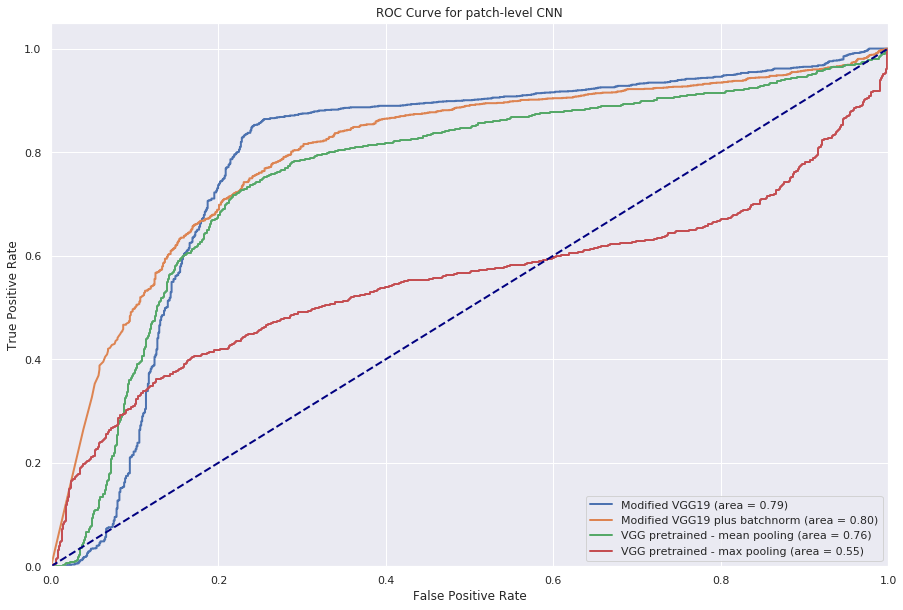

In [58]:
%matplotlib inline

model_files = ['conv2d_v2_std_epoch4.pt', 'conv2d_v2_batchnorm_std_epoch4.pt', 'transfer_epoch4_v2.pt', 'transfer_epoch4_v2_maxpool.pt']
model_names = ['Modified VGG19', 'Modified VGG19 plus batchnorm', 'VGG pretrained - mean pooling', 'VGG pretrained - max pooling']

plt.figure(figsize=(15,10))
lw = 2
for i in range(len(model_names)):
    plt.plot(fprs[i], tprs[i], color=sns.color_palette()[i], lw=lw, label='%s (area = %0.2f)' % (model_names[i], rocs[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for patch-level CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('roc_all_models.png')
plt.show()

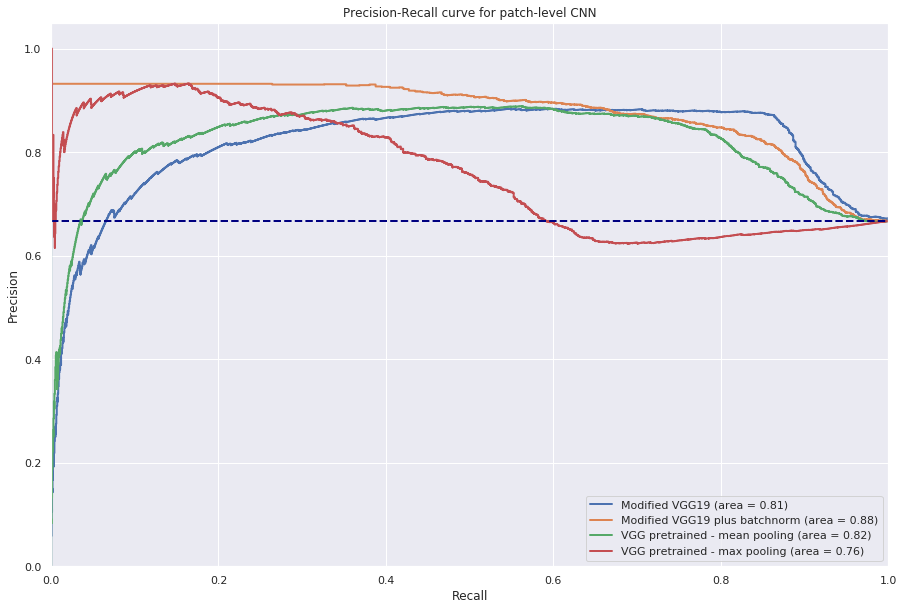

In [65]:
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score

plt.figure(figsize=(15,10))
for i in range(len(model_names)):
    average_precision = average_precision_score(all_labels[i], all_preds[i])
    precision, recall, thresholds = precision_recall_curve(all_labels[i], all_preds[i])
    plt.step(recall, precision, color=sns.color_palette()[i], where='post', lw=lw, label='%s (area = %0.2f)' % (model_names[i], average_precision))
plt.plot([0, 1], [0.6667, 0.6667], color='navy', lw=lw, linestyle='--')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('Precision-Recall curve for patch-level CNN'.format(
          average_precision))
plt.savefig('prc_all_models.png')
plt.show()

In [114]:
precision, recall, thresholds = precision_recall_curve(all_labels[1], all_preds[1])
arg = np.where(recall > 0.85)[-1][-1]
print(arg)
print(precision[arg])
print(np.mean(all_preds[1] > thresholds[arg]))
thresholds[arg]

820
0.821917808219178
0.6893424036281179


0.6094117164611816

### Patient-level prediction

In [108]:
def predict_label(prob, cutoff=0.6094117164611816):
    if prob > cutoff:
        return 1
    return 0

In [109]:
patch_labels = {k:[] for k in utils.labels_dict}
with open('patch_results.txt') as infile:
    for line in infile:
        modname, modfile, prob = line.strip().split('\t')
        if modname != 'Conv2D with batchnorm':
            continue
        patient = modfile.split('reg')[1].split('_')[0]
        patch_labels[patient].append(predict_label(float(prob)))

In [110]:
patient_labels = {}
for patient, labels in patch_labels.items():
    maj_vote = (np.mean(labels) > 0.5)
    print('patient', patient, '% positive patches:', np.mean(labels))
    print('patient', patient, 'true label:', utils.labels_dict[patient][1])
    patient_labels[patient] = int(maj_vote)

patient 005 % positive patches: 0.36848072562358275
patient 005 true label: 0
patient 006 % positive patches: 0.5154394299287411
patient 006 true label: 1
patient 017 % positive patches: 0.9846491228070176
patient 017 true label: 1
patient 019 % positive patches: 0.8909512761020881
patient 019 true label: 1
patient 011 % positive patches: nan
patient 011 true label: 0
patient 016 % positive patches: nan
patient 016 true label: 1
patient 030 % positive patches: nan
patient 030 true label: 1
patient 023 % positive patches: nan
patient 023 true label: 1
patient 004 % positive patches: nan
patient 004 true label: 0
patient 015 % positive patches: nan
patient 015 true label: 0
patient 014 % positive patches: nan
patient 014 true label: 1
patient 024 % positive patches: nan
patient 024 true label: 1
patient 020 % positive patches: nan
patient 020 true label: 1
patient 007 % positive patches: nan
patient 007 true label: 1
patient 008 % positive patches: nan
patient 008 true label: 1
patient 0